In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np
import math as m

from astropy import constants as const
from astropy.stats import sigma_clip

from glob import glob

import reduce_dblspec 
import pipeline

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table
from photutils import centroid_com
from scipy import asarray as ar,exp
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support()


from astropy import modeling
from astropy import constants as cnst

In [2]:
#ST-1
ST1_1 = fits.open('DoubleSpec/20170519/red0071.fits') #
#print(ST1_1[0].header)
ST1_1[0].header[41:]
# ST1_2 = fits.open('DoubleSpec/20170519/red0072.fits') #
# ST1_3 = fits.open('DoubleSpec/20170519/red0073.fits') #


#ST-2
# ST2_1 = fits.open('DoubleSpec/20170519/red0075.fits') #
# ST2_2 = fits.open('DoubleSpec/20170519/red0076.fits') #
# ST2_3 = fits.open('DoubleSpec/20170519/red0077.fits') #
# ST2_4 = fits.open('DoubleSpec/20170519/red0078.fits') #
# ST2_5 = fits.open('DoubleSpec/20170519/red0079.fits') #


# #what each should be
# StarTrek1_fn = ('57607497318756-StarTrek')
# StarTrek2_fn = ('57607497515484-StarTrek')


# #ST1.info()
# hdr = ST1[0].header
# hdr['OBJECT']


# #make a for loop to print all headers so know which file to change

RA      = '08:12:60.00'        / Right Ascencion                                
DEC     = '+36:11:51.1'        / Declination                                    
HOURANG = 'W04:23:23.6'        / Hour angle, TCS format                         
HA      = '+04:23:23.6'        / Hour angle                                     
AIRMASS = '1.663   '           / Airmass                                        
TELID   = '200     '           / telescope ID                                   
TELFOCUS= '40.77 mm'           / focus position                                 
CASSPA  = '72.41   '           / cass ring angle                                
PARALLAC= '72.27   '           / parallactic angle                              
DHE     = 'SDSU Gen III'       / controller info                                
CCDTEMP = '130.015 '           / detector mount temp                            
SOFTVER = '3.4     '           / software version                               
HDR_REV = '4.3     '        

In [3]:
myarray=np.arange(71,80,1)
names =[]
for i in myarray:
    print(i)
    if i <= 73: #ST1
        path = 'DoubleSpec/20170519/red00{}.fits'.format(i)
        file = fits.open(path)
        hdr = file[0].header
        target = str(hdr['OBJECT'])
        names.append(target)
        file.close()

#     elif i >=75: #ST2
#         path = 'DoubleSpec/20170519/red00{}.fits'.format(i)
#         file = fits.open(path)
#         hdr = file[0].header
#         target = str(hdr['OBJECT'])
#         names.append(target)
#         file.close()
    else:
        print('went here')
print(names)

71
72
73
74
went here
75
went here
76
went here
77
went here
78
went here
79
went here
['57607497318756-StarTrek', '57607497318756-StarTrek', '57607497318756-StarTrek']


In [4]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Red DS

In [5]:


#flatid = 'DomeFlat'

#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20170519/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20170519/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = '57607497318756-StarTrek'
all_side_files_red = 'DoubleSpec/20170519/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20170519/blue*.fits'#BLUE side
#target = fits.open('DoubleSpec/20151108/red0093.fits') #use these to get targetid
#target[0].header
##################################################

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


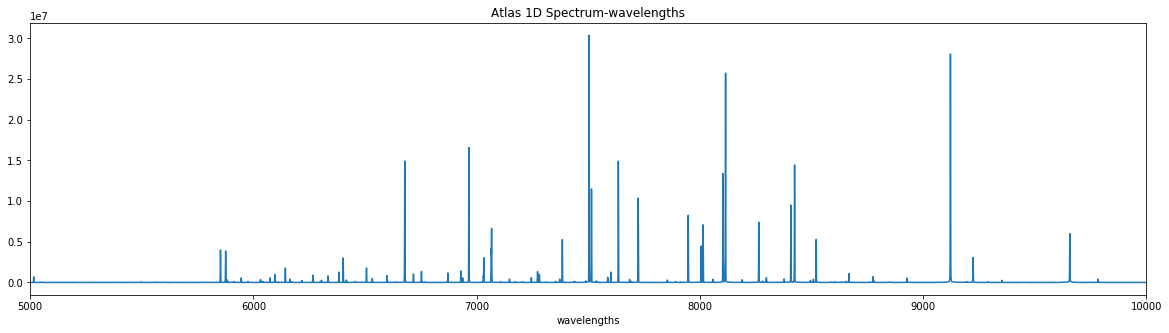

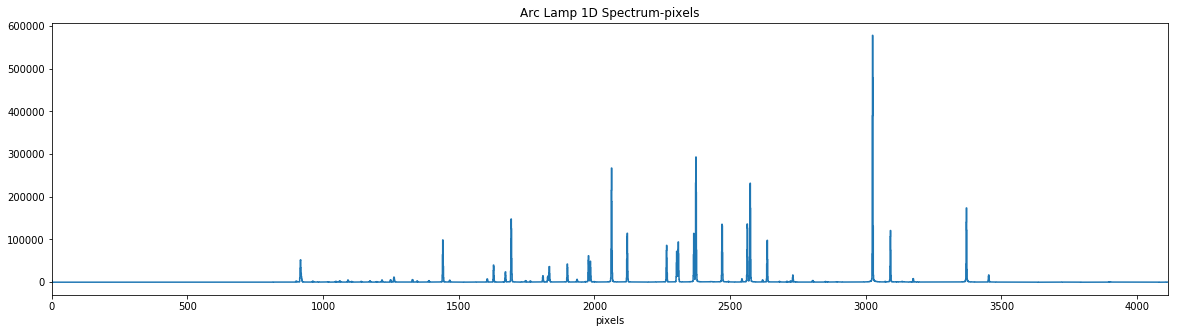

In [6]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


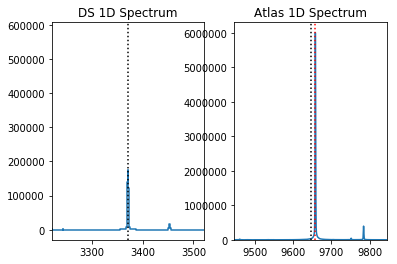

In [7]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(3371,9645,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist) #3026,9105

#collect guesses here ~5 seems good
#pixel_guesses = [917,1672,1628,2303,2564,2636,3371] #[3026,
#atlas_lines = [6402.246,7032.4131,6965.4307,8006.1567,8408.2096,8521.4422,9657.7863] #[9224.4992,

pixel_guesses = [3024,2373,2062,1672,3370,1466]
atlas_lines = [9122.9674,8115.311,7635.106,7032.4131,9657.7863,6717.043]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line NeI at wl=6266.495: "Guessed line's peak to base ratio is 4.437639492098258, which is less than 10"
Failed to find line ArI at wl=6296.8722: "Tried to find peak at 1192.1234177939348 but it's in a valley, not a peak"
Failed to find line NeI at wl=6304.789: "Guessed line's peak to base ratio is 6.61726873099301, which is less than 10"
Failed to find line NeI at wl=6334.4278: "Guessed line's peak to base ratio is 8.25409168187282, which is less than 10"
Failed to find line NeI at wl=6382.9917: "Guessed line's peak to base ratio is 8.609389628374734, which is less than 10"
Failed to find line NeI at wl=6402.246: "Guessed line's peak to base ratio is 7.755387299896906, which is less than 10"
Failed to find line ArI at wl=6416.3071: "Guessed line's peak to base ratio is 0.8763909831346365, which is less than 10"
Failed to find line KrI at wl=6456.291: "Guessed line's peak to base ratio is 0.7597161354275233, which is less than 10"
Failed to find line NeI at wl=6506.5281:

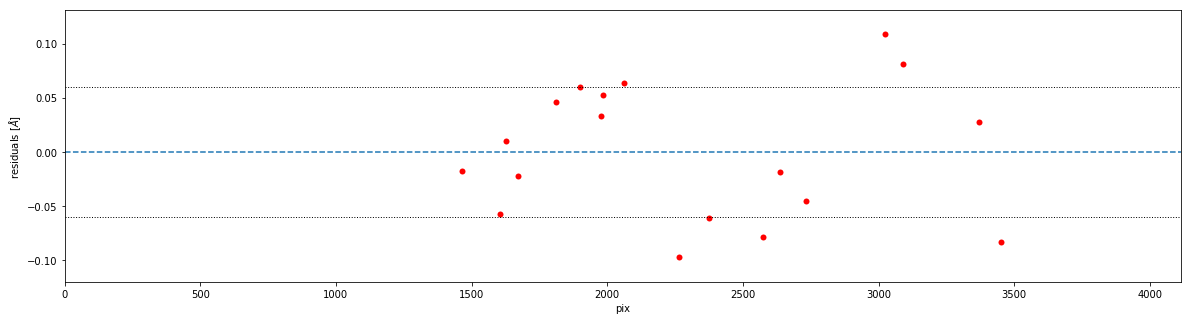

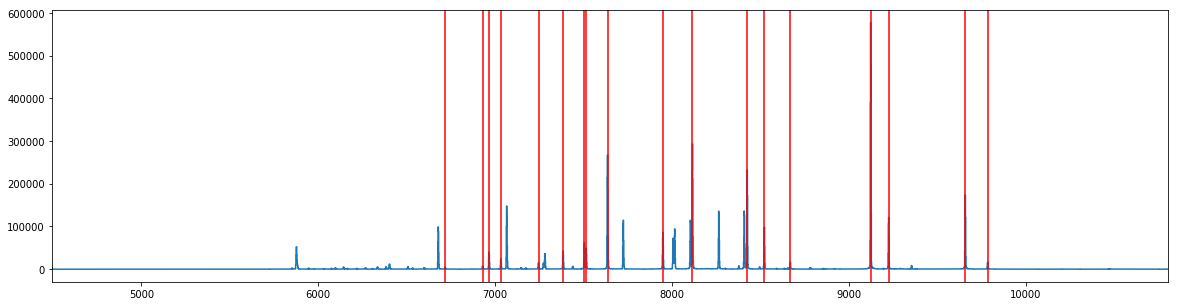

In [8]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

# Extracting 1d spectrum (sky subt & stacking)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


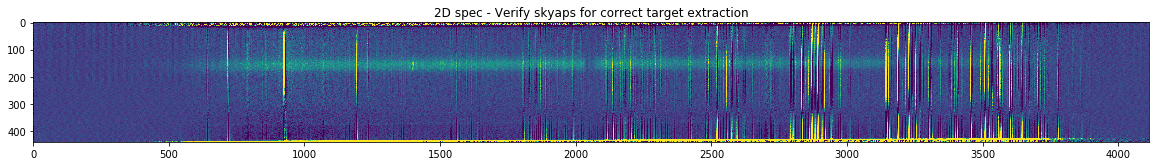

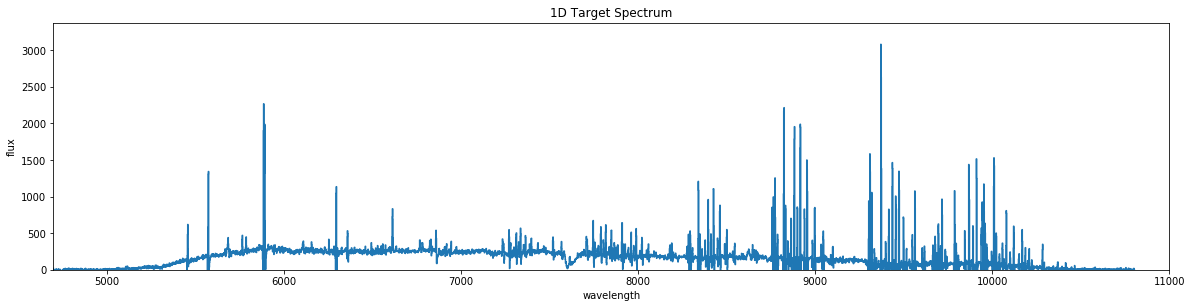

In [9]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red= [(20,30),(260,375)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (155,175)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??

#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

# Starting 2nd reduction tech. for rot. curves

In [10]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red #avg(ok median) values from all images
best_emission_skyaps = skyaps_red #best sky aps
best_emission_model = model_red #best sky tilt estimation
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

<Figure size 720x1800 with 0 Axes>

# emission line centroids

In [11]:
#trying to understand where spec cut is in below cell

subimg2.data[0].shape

(4114,)

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (216, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


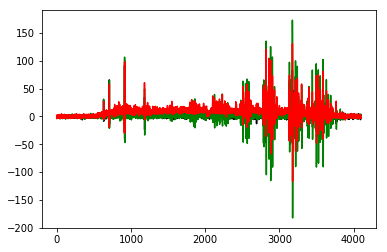

In [12]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(35,250) #target location 35,210 originally 43,204 in 1dspec,live values are a test
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[170],color='g')#near opposite galaxy edge
plt.plot(flux_data[105],color='r')#near galaxy center


#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

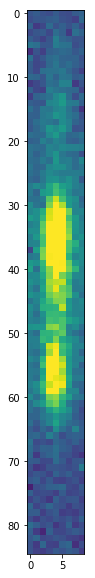

In [13]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################


testingthis=subimg2.data[115:200,1396:1405] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1396,1405) #(1289, 1297)
bestline_range_correction = (1386,1395)#(1279,1287) #includes shortened wl range
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

badrow: 13 mean value: -1.682739588748727 amplitude: 5.115666425110959
badrow: 20 mean value: -0.03860773488388638 amplitude: 4.229995876786123
badrow: 30 mean value: -5.576529156551675 amplitude: 3.8380034863856594


(1395, 1403)

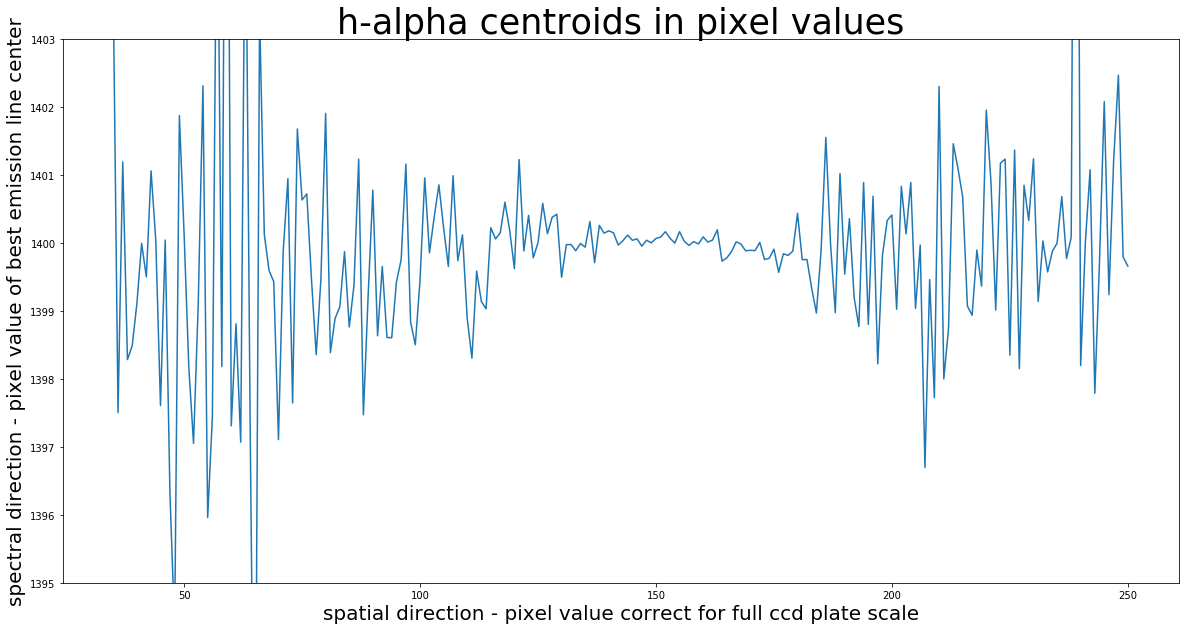

In [14]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0])))) #all rows, full ccd wl range
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1396:1405]#[1289:1297] #isolate wls around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1386:1395]#[:,1279:1287] #use 'bestline_range_correction' range

#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for count,row in enumerate(flux_data_short): 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_ys, centroid_xs = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys) #(space axis, so always zero)
    #print('why are these zero?',centroid_xs, centroid_ys) #x & y switched for some reason...
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = np.arange(len(row)) #ar(range(len(row)))
    y = row #flux values per wl in shortened target wl region, cycle goes thru each space row
    mean = centroid_xs
    #print('mean:',mean,'max:',max(y))
    if mean <=0.0:
        print('badrow:',count,'mean value:',mean, 'amplitude:',max(y))
     #   g_init = models.Gaussian1D(amplitude=max(y), mean=0, stddev=2.)
    #else:
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=1.5)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################
#plt.ylim(1285,1305)
#plt.ylim(1291,1295)
plt.ylim(1395,1403)

(1395, 1409)

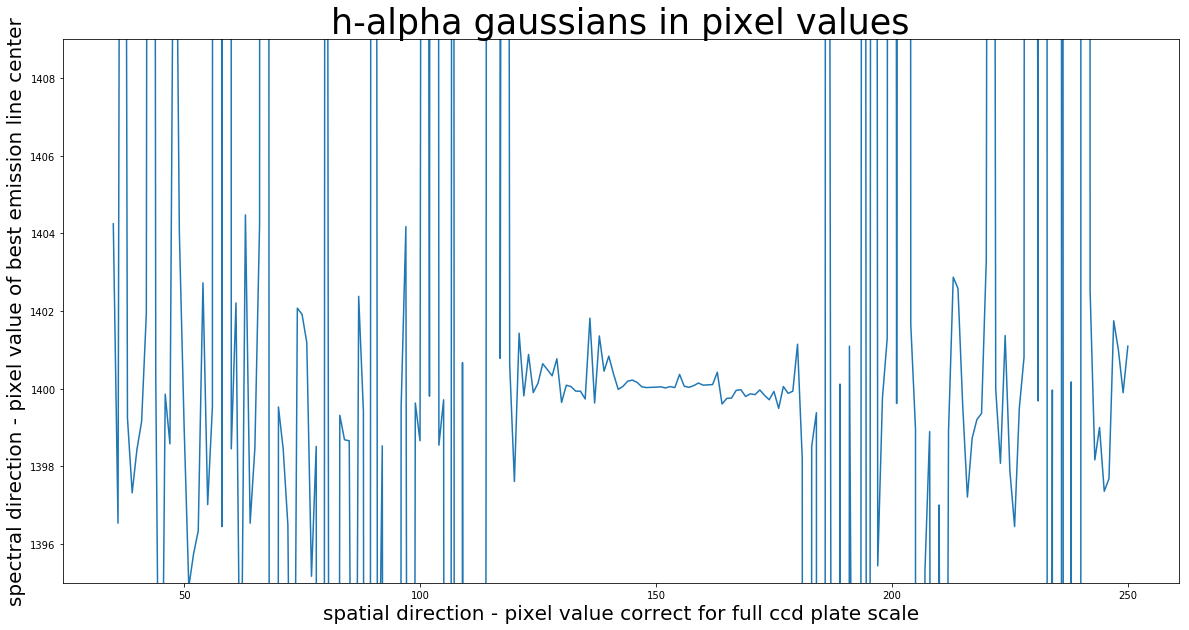

In [15]:
# plt.plot(centroids_pix)
# plt.ylim(-50,10)

plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values',fontsize=35)
#plt.ylim(1380,1420)
plt.ylim(1395,1409)

In [16]:
#collecting indicies of bad matrices


matrix = np.arange(0,len(means_unc),1)
print('these should be the same, if not explore:',len(matrix),len(gaussian_means))

badindices = []
for i in matrix:
    #print()
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i, means_unc[i])
        badindices.append(i)
    else:
        ok = 'ok'
        #print(ok)
        #print(means_unc[i])
print('number of bad fits is:',len(badindices))

these should be the same, if not explore: 216 216
bad matrix at array: 2 None
bad matrix at array: 8 None
bad matrix at array: 14 None
bad matrix at array: 15 None
bad matrix at array: 22 None
bad matrix at array: 27 None
bad matrix at array: 32 None
bad matrix at array: 34 None
bad matrix at array: 44 None
bad matrix at array: 45 None
bad matrix at array: 46 None
bad matrix at array: 47 None
bad matrix at array: 54 None
bad matrix at array: 55 None
bad matrix at array: 58 None
bad matrix at array: 59 None
bad matrix at array: 60 None
bad matrix at array: 62 None
bad matrix at array: 63 None
bad matrix at array: 66 None
bad matrix at array: 68 None
bad matrix at array: 71 None
bad matrix at array: 72 None
bad matrix at array: 73 None
bad matrix at array: 75 None
bad matrix at array: 76 None
bad matrix at array: 77 None
bad matrix at array: 78 None
bad matrix at array: 80 None
bad matrix at array: 81 None
bad matrix at array: 83 None
bad matrix at array: 147 None
bad matrix at array: 15

In [17]:
#masking bad uncertaiinty values


evenmore_badindices=[]
masked_gsigs_means=[]
for i in  range(len(means_unc)):
    #print(type(means_unc[i]))
    #if type(means_unc[i][1][1]) != np.ndarray:
    if type(means_unc[i]) == np.ndarray: #'NoneType':
        gmatrix_unc=means_unc[i][1][1]
        #print(i)
    #b/c these are the good fits, keep those vals
    else:
        gmatrix_unc=np.nan
        evenmore_bad = i
        evenmore_badindices.append(evenmore_bad)
        #print(i)
    #print(i, gmatrix_unc)
    masked_gsigs_means.append(gmatrix_unc)
evenmore_badindices = np.array(evenmore_badindices)
masked_gsigs_means = np.array(masked_gsigs_means)
#print(masked_gsigs_means)
print(evenmore_badindices,len(evenmore_badindices),badindices) #good they match, as they should

[  2   8  14  15  22  27  32  34  44  45  46  47  54  55  58  59  60  62
  63  66  68  71  72  73  75  76  77  78  80  81  83 147 150 151 153 155
 158 159 160 161 165 167 168 171 174 176 186 194 195 197 198 201 202 205
 206] 55 [2, 8, 14, 15, 22, 27, 32, 34, 44, 45, 46, 47, 54, 55, 58, 59, 60, 62, 63, 66, 68, 71, 72, 73, 75, 76, 77, 78, 80, 81, 83, 147, 150, 151, 153, 155, 158, 159, 160, 161, 165, 167, 168, 171, 174, 176, 186, 194, 195, 197, 198, 201, 202, 205, 206]


In [18]:
#masking bad gaussian values
more2_badindices=[]
more_badindices=[]
masked_gaussian_means=[]
for i in  range(len(gaussian_means)):
    #b/c bad fit produced no cov matrix
    if i in badindices:
        gaussian_means[i] = np.nan
        #print('sdjbine09g8boernh589430gt9fjoiwenvg50348jgv')
    #b/c mean value shouldnt be outside this pixel range
    elif gaussian_means[i] <=0.0:
        gaussian_means[i]=np.nan
        more2_bads = i
        more2_badindices.append(more2_bads)
    elif gaussian_means[i] >=9.0:
        gaussian_means[i] = np.nan
        more2_bads=i
        more2_badindices.append(more2_bads)
    #b/c these are the good fits, keep those vals
    else:
        gaussian_means[i]=gaussian_means[i]
    #print(i,gaussian_means[i])
    masked_gaussian_means.append(gaussian_means[i])
#more_badindices = np.array(more_badindices)
more2_badindices = np.array(more2_badindices)
masked_gaussian_means = np.array(masked_gaussian_means)



In [19]:

# changing those (evenmore bad indicies) values to nan in the uncertainity array


fullmask_sigma=[]
for i in  range(len(masked_gsigs_means)):
    #b/c bad fit produced no cov matrix
    if i in more2_badindices:
        masked_gsigs_means[i] = np.nan
    #b/c these are the good fits, keep those vals
    else:
        masked_gsigs_means[i]=masked_gsigs_means[i]
    #print(i,masked_gsigs_means[i])
    fullmask_sigma.append(masked_gsigs_means[i])
fullmask_sigma = np.array(fullmask_sigma)



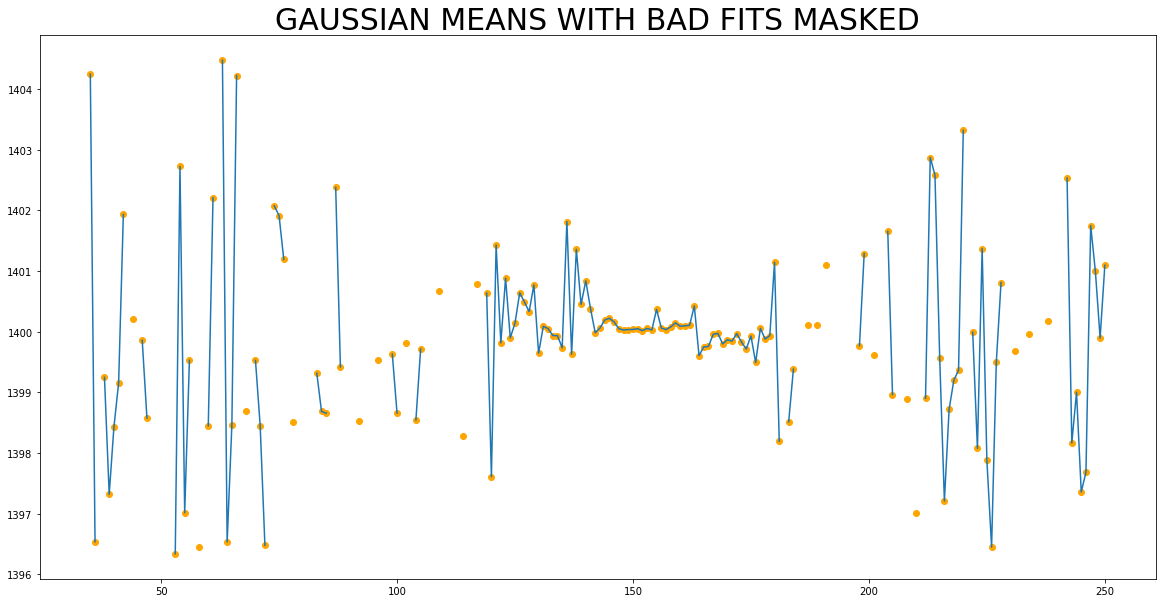

In [20]:
gaussmeans_specpix_fullccd_MASKED = masked_gaussian_means + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd_MASKED = masked_gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,c='orange')
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)


#plt.ylim(1280,1300)
#plt.ylim(1289,1295)



(1396, 1407)

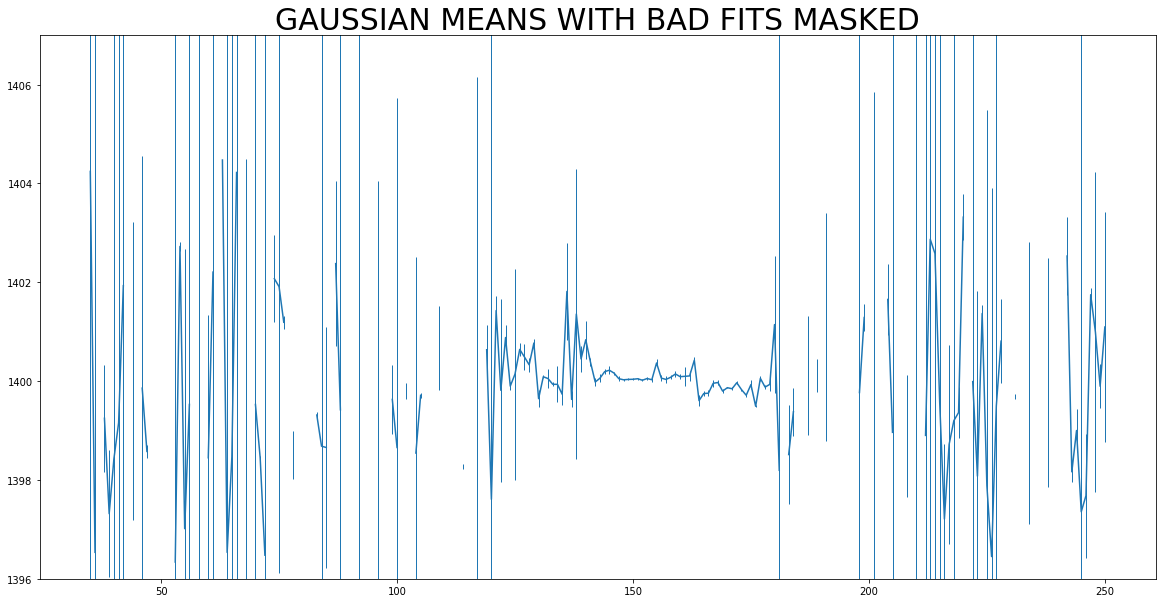

In [21]:
#with error bars


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1) #,alpha=0.5)
plt.ylim(1396,1407)

(1393, 1407)

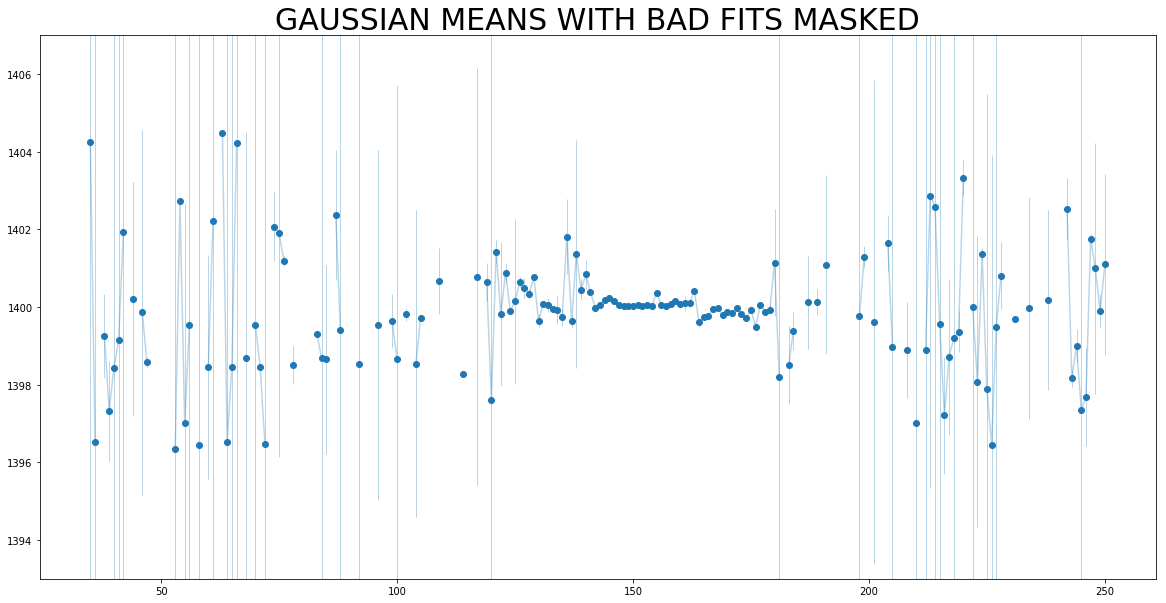

In [22]:
plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1,alpha=.3)
plt.ylim(1393,1407)

 # pix --> wl

(6608, 6625)

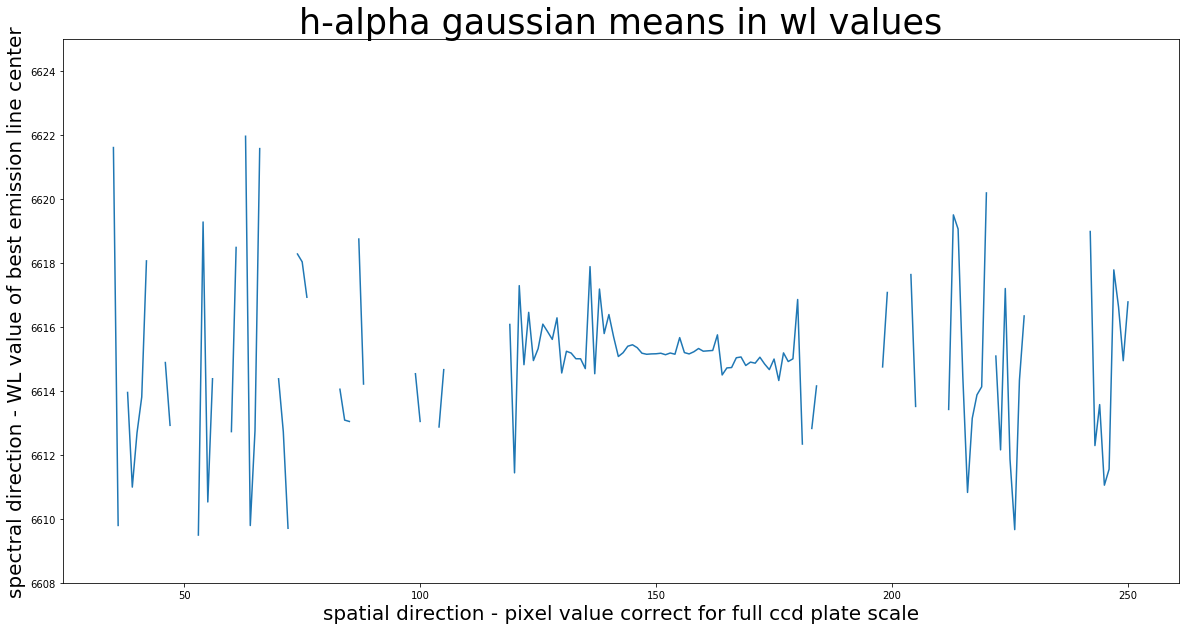

In [23]:
#applies ds


#gotta figure a way to keep masked values masked and not just add to a val from corrections
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussian means in wl values',fontsize=35)
##########################################################
#plt.ylim(6620,6625)
plt.ylim(6608,6625)
#plt.ylim(6616,6628)

# spectral core

In [24]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(masked_gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print('pix value of halpha core spectral axis is:',bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

pix value of halpha core spectral axis is: 1399.8143394710555
Best emission line "core" wl (based on gaussian fits) is: 6614.820476603026 Angstrom


In [25]:
wl_gauss_test = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
average = np.nanmean(wl_gauss_test)
#print(wl_gauss_test,'thank you next',wl_gaussians,'average of the averaged',average)




# spatial core by sections

(216, 4104)
1395 1386
shape of first section: (216, 10) matches shape of second section: (216, 10)
shape of first section 2d: (216, 1)
shape of second section 2d: (216, 1)
first section centroid y,x: 0.0 115.10788323701341
second section centroid y,x: 0.0 116.40969614395598
This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS 115.75878969048469
Pixel Value of core along spatial axis wrt full CCD size 150.7587896904847


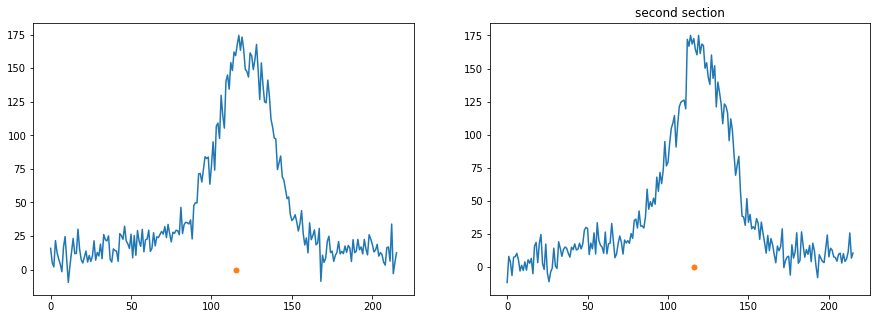

In [26]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
print(np.shape(flux_data))#(168,4104) #note that this is missing those wl's


#making arrays surrounding best emission line
################################################
upperha = bestline_range_correction[1]
lowerha = bestline_range_correction[0]
print(bestline_range_correction[1],bestline_range_correction[0])
#################################################
width_sections = 10 #reduced from 50 to 25 to avoid cosmic rays skewing to higher pix side
upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
lower_one = upper_one - width_sections
lower_two = upperha + 1 #giving it some distance
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
y_first, x_first = centroid_com(first_section2d)
y_second, x_second = centroid_com(second_section2d)
print('first section centroid y,x:',x_first,y_first)
print('second section centroid y,x:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)
ax2.set_title('second section')
#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

#FULL CCD pixel value of core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)

# pix --> kpc

In [27]:
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [28]:
#actual converting for loop CENTROIDS pixels to kpc
## good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 27.3*u.Mpc # distance of object (host) from us
#####note for G-1, google sheet has G dist =27.7Mpc but SAGA1 paper =28Mpc
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections = r_in_kpc #/ (1*u.kpc)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)

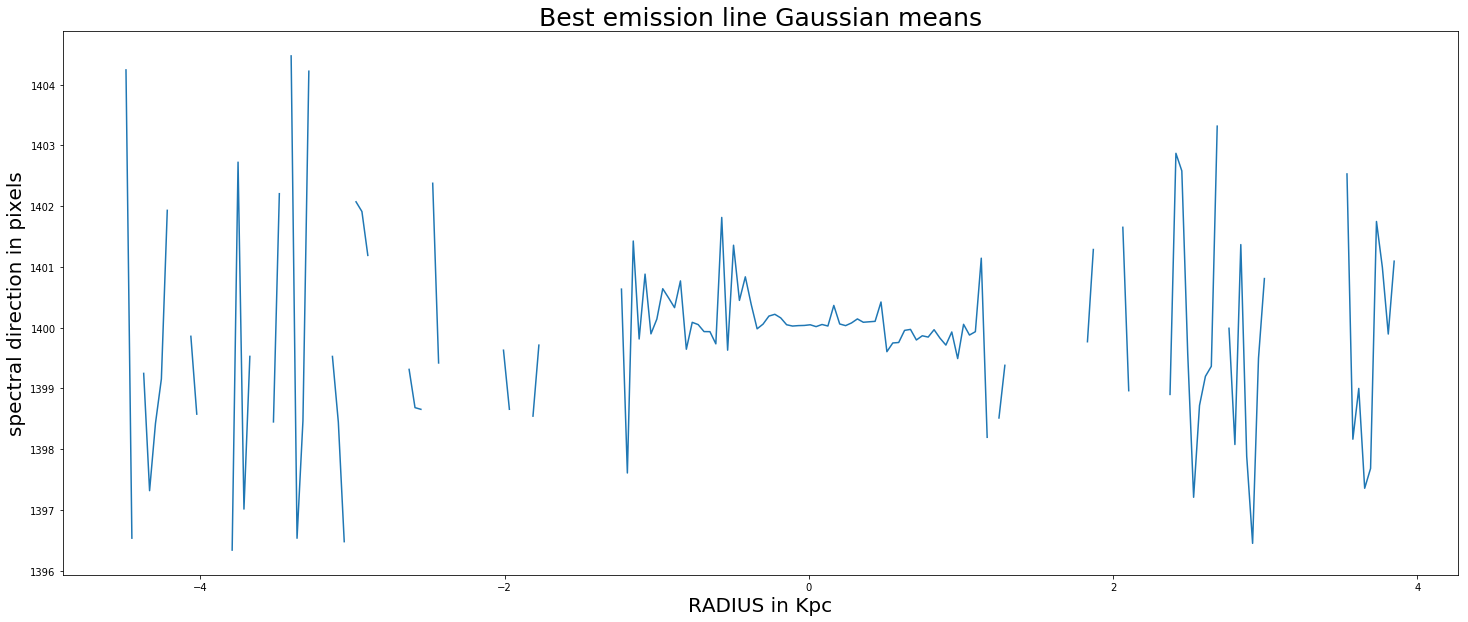

In [29]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd_MASKED)

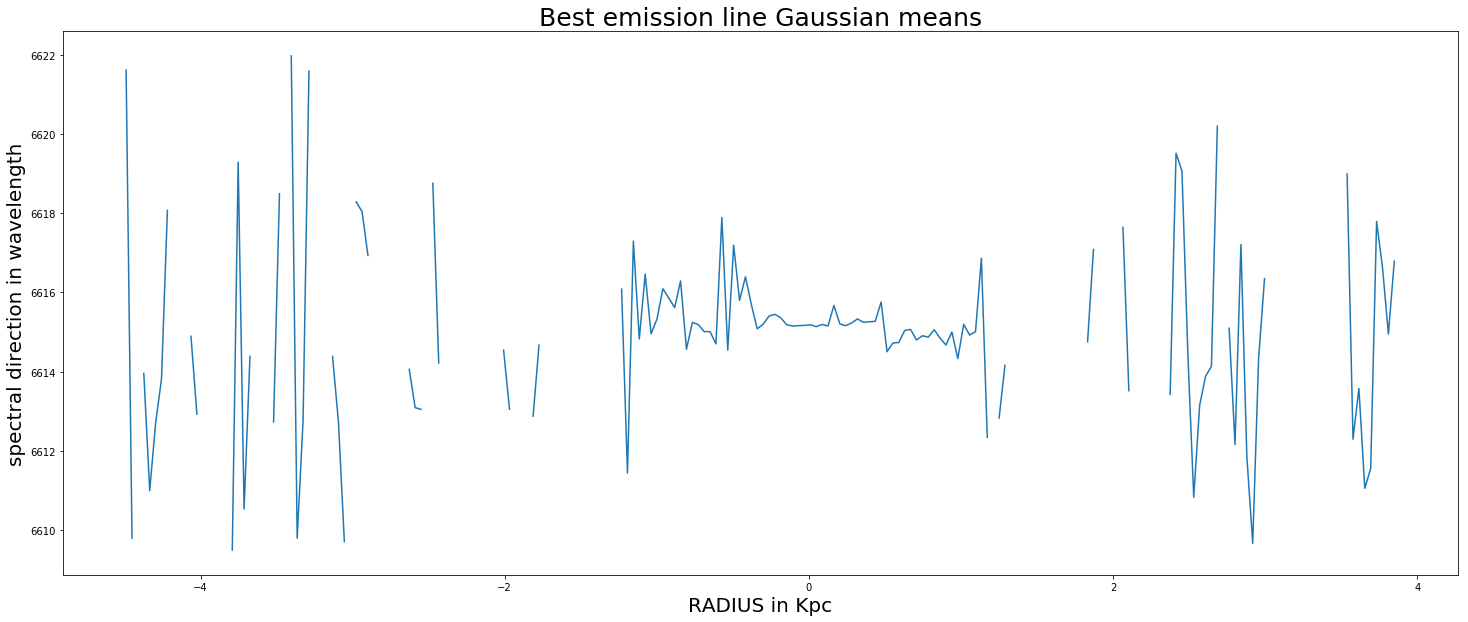

In [30]:
#GAUSSIAN MEANS plot with wl & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections * u.kpc, wl_gaussians)

# pix ---> kpc (doesnt rely on distance from core)

In [31]:
### doesnt rely on distance from core



distances_sections_target=[]
more_sections_target = []

#converts pix to kpc and saves as quantity list
for i in target_spacepix_fullccd:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 27.3*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections_target = r_in_kpc #/ (1*u.kpc)
    distances_sections_target.append(more_sections_target.value)
distances_sections_target = np.array(distances_sections_target)

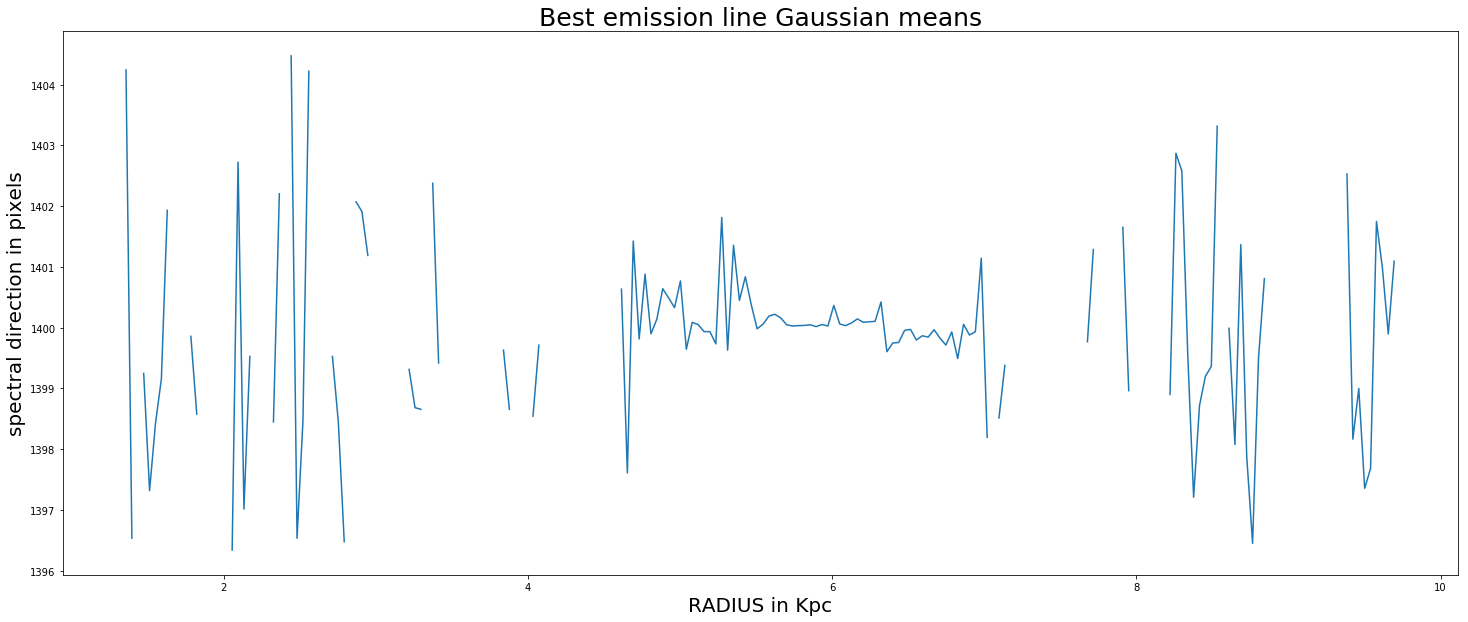

In [32]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections_target * u.kpc, gaussmeans_specpix_fullccd_MASKED)

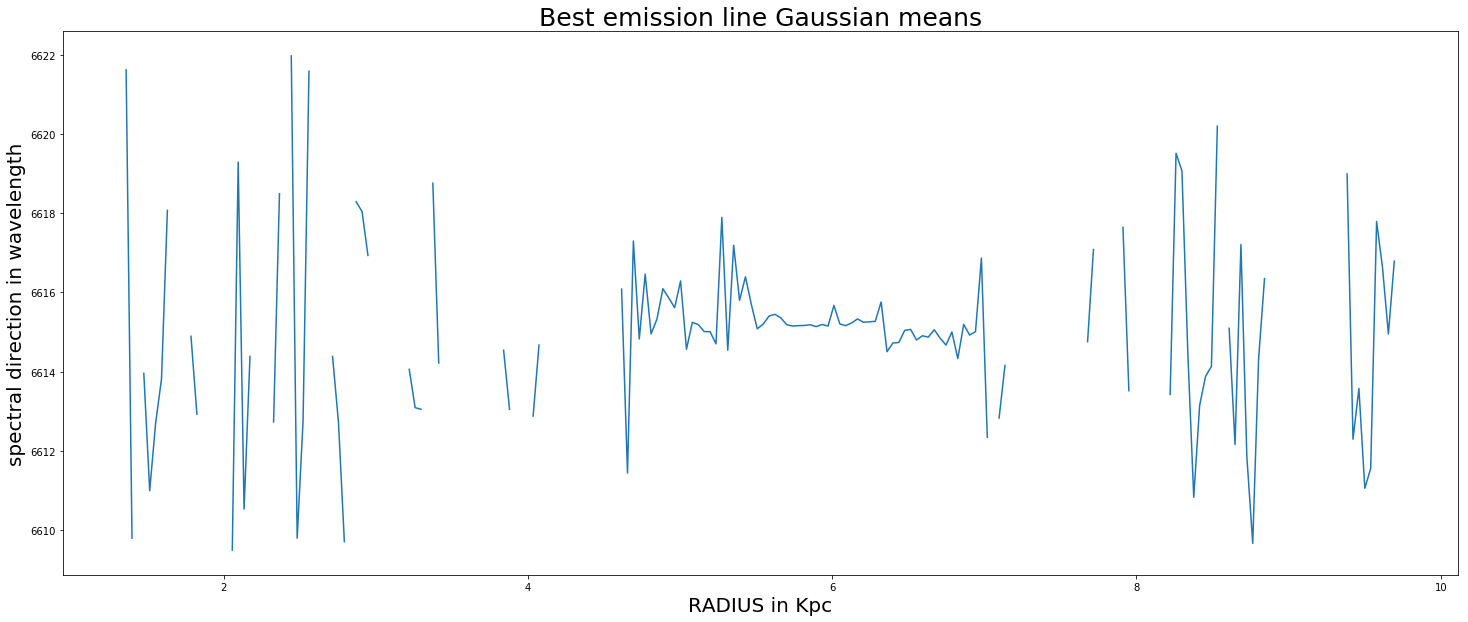

In [33]:
plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections_target * u.kpc, wl_gaussians)

# converting pix ---> wl ------> vel

In [34]:
#convert pix to wl via ds
###################################################################
#centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd_MASKED)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
#core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [35]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
#v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
#v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
v_core = ((average/(6563*u.angstrom)) -1) * const.c #core velocity


###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
#y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core.to('km/s'))
print(average.value-6563)

velocity of best emission line's spectral 'core': 2369.3378981018705 km / s
51.86909880582243


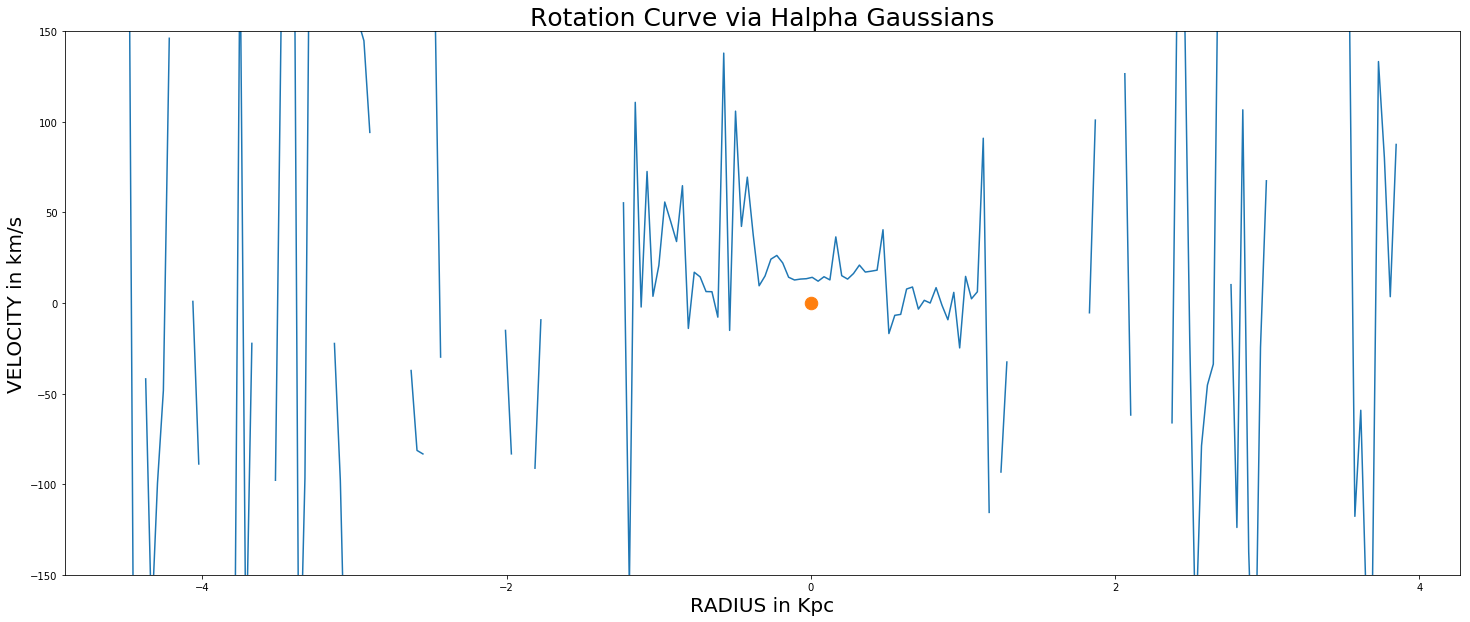

In [36]:
# used core from sections

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-150,150) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

(-250, 250)

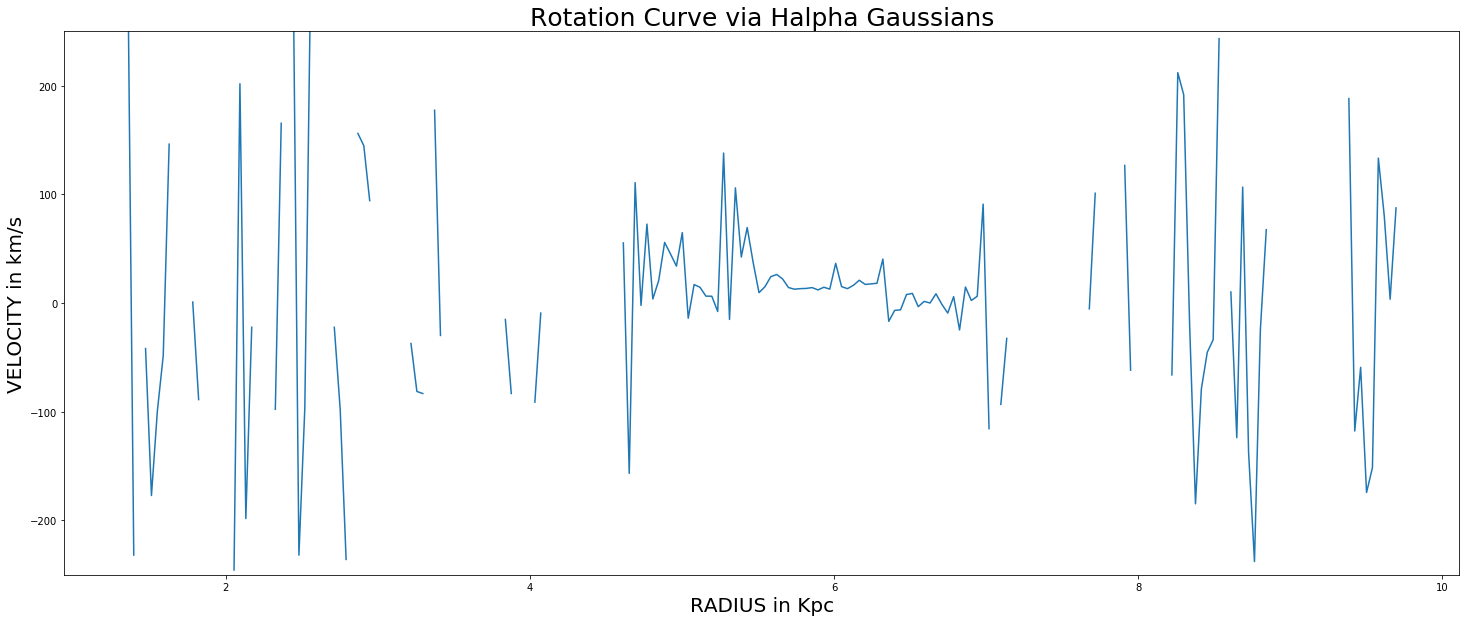

In [37]:
#no core yet -use when letting model decide

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections_target * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

# errorbars

In [38]:
#newer way trying to get core from eriks model

########################################### fullmask_sigma is in pixels
sigma_gauss_pix = np.sqrt(np.abs(fullmask_sigma)) #taking sqrt of unc to get a true sigma
################################################
#correct to full ccd pix scale
#print(sigma_gauss_pix)
means_Wsigma_fullccd = masked_gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocitys_unc

v_unc (216,)


In [39]:
dist_kpc = distances_sections * u.kpc

(-150, 150)

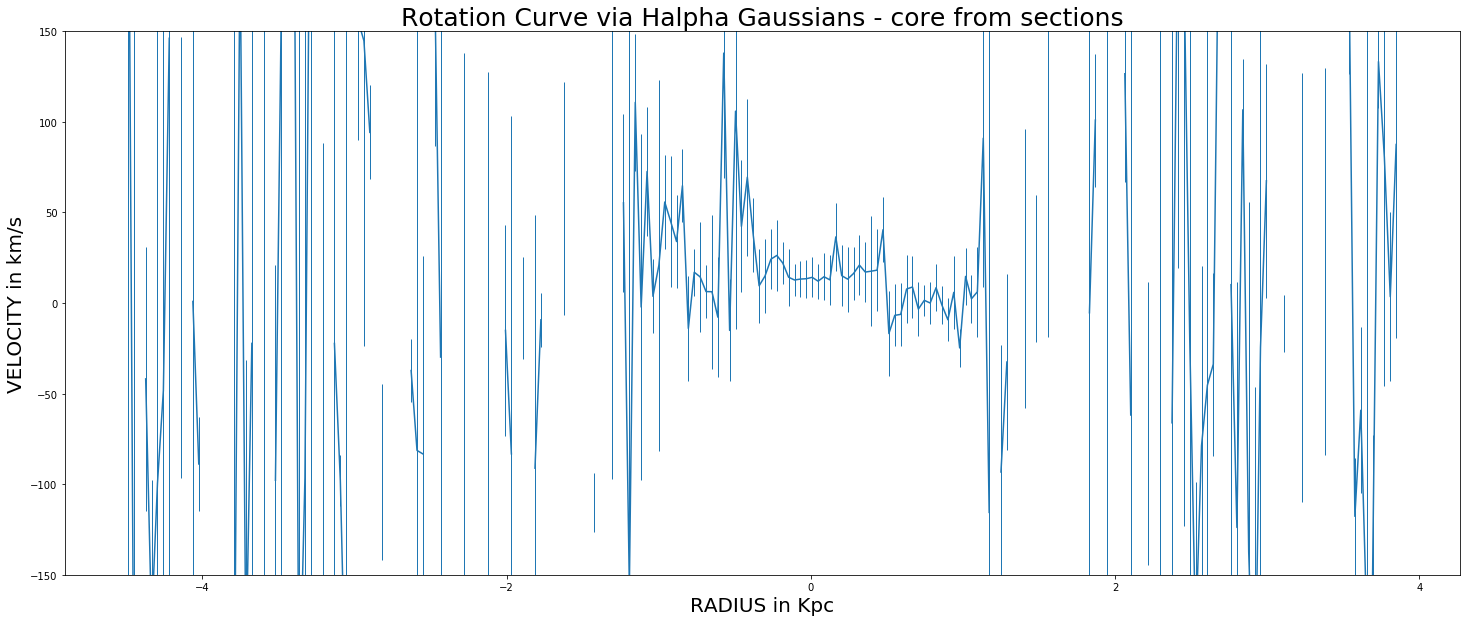

In [40]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians - core from sections', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.errorbar(np.asarray(dist_kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1)
plt.ylim(-150,150) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

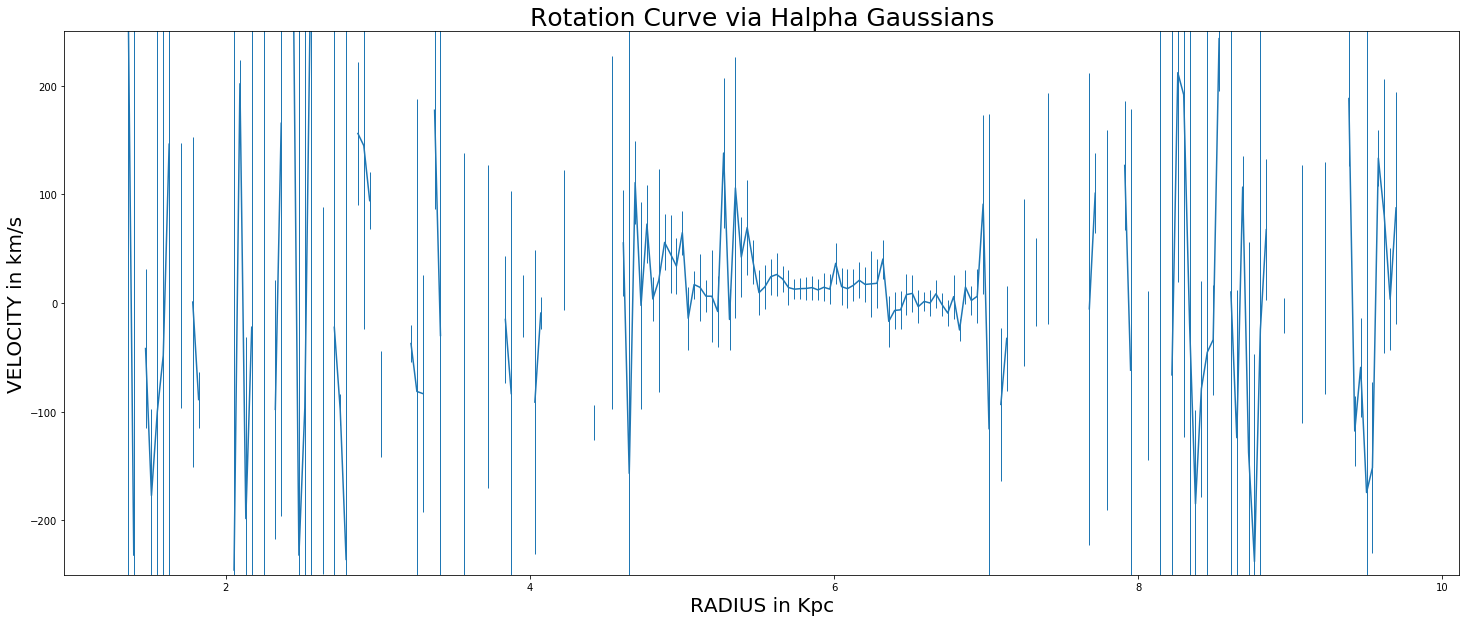

In [41]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.errorbar(distances_sections_target, y_axis_Gvelocity.value,yerr=v_unc.value,elinewidth=1) #think needed .value & rm *kpc b/c didnt import quantity_support (see Anak-1)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

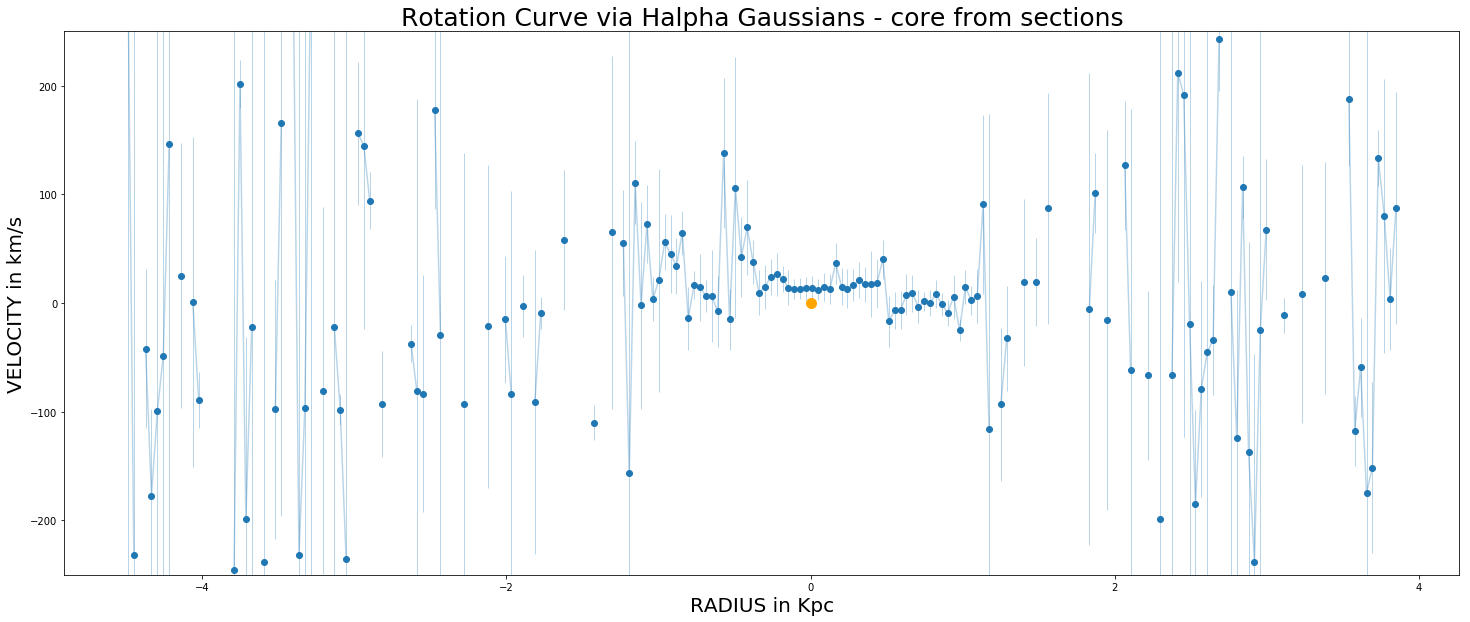

In [42]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians - core from sections', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.scatter(distances_sections * u.kpc, y_axis_Gvelocity)
plt.plot(0,0,'.', markersize=20,color='orange')
plt.errorbar(np.asarray(distances_sections * u.kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1,alpha=0.3)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

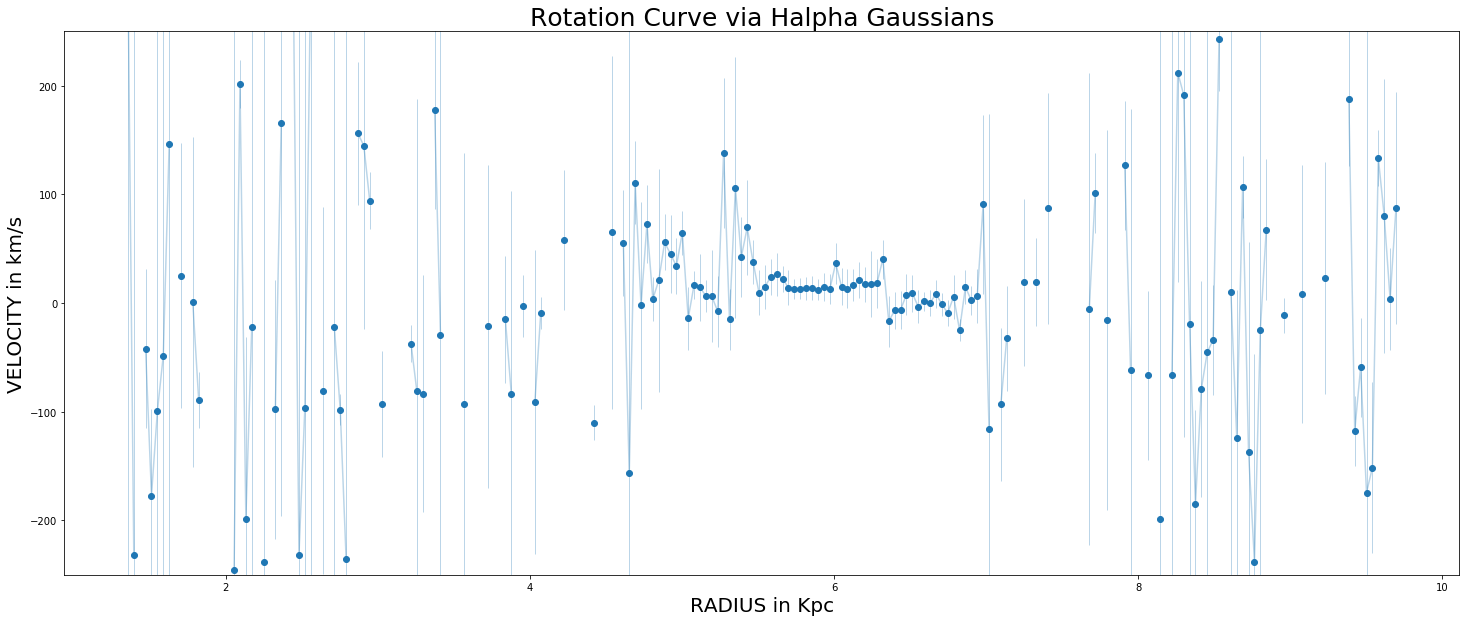

In [43]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.scatter(distances_sections_target * u.kpc, y_axis_Gvelocity)
plt.errorbar(distances_sections_target , y_axis_Gvelocity.value,yerr=v_unc.value,elinewidth=1,alpha=0.3)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

# mass modeling

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    alpha  beta sigma omega
    ----- ----- ----- -----
    1e-05 1e-05 -50.0   0.3


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


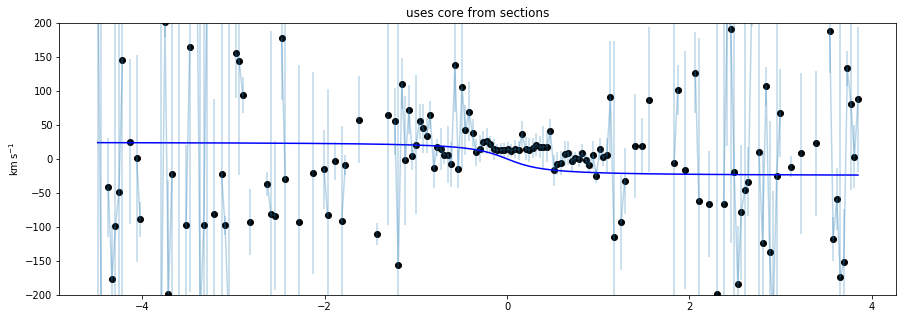

In [47]:
#with ccore from sections


#arr=np.asarray


@models.custom_model #very necessary line
def eriksmodel(r, alpha=.00001, beta=.00001, sigma=-50, omega=.3):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, distances_sections[nan_msk], y_axis_Gvelocity.value[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('uses core from sections');

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    alpha  beta sigma  omega v_offset
    ----- ----- ------ ----- --------
    0.001 0.001 -150.0   1.0      0.0


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


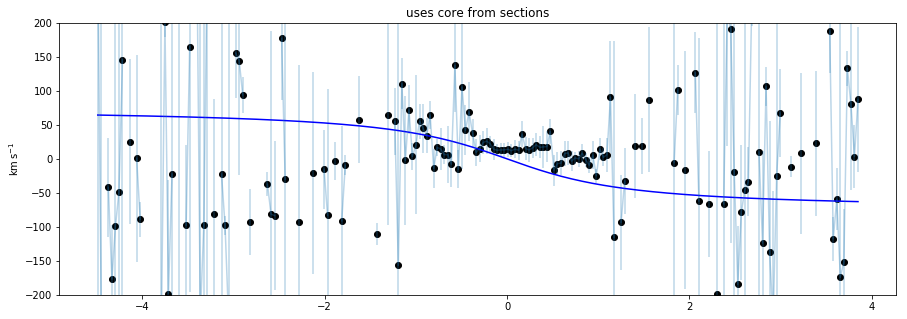

In [48]:
#with ccore from sections


#takes out nan's so fit will actually do a fit
arr = np.asarray
@custom_model #very necessary line
def eriksmodel(r,alpha=.001, beta=.001, sigma=-150, omega=1, v_offset=0):
    #dr = r - r_cen
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi + v_offset)

m_init = eriksmodel(bounds={'alpha':(.0000001,.01), 'beta':(.0000001,.01),'sigma': (-200,200),'omega':(0,10)})
#m_init.r_cen=6



fit = LevMarLSQFitter()
#print('here',m_init)
##m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections, y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections,y_axis_Gvelocity,yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('uses core from sections');

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta sigma omega v_offset
    ----- ----- ----- ----- ----- --------
      6.0 0.001 0.001  50.0   1.0      0.0


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


(-200, 200)

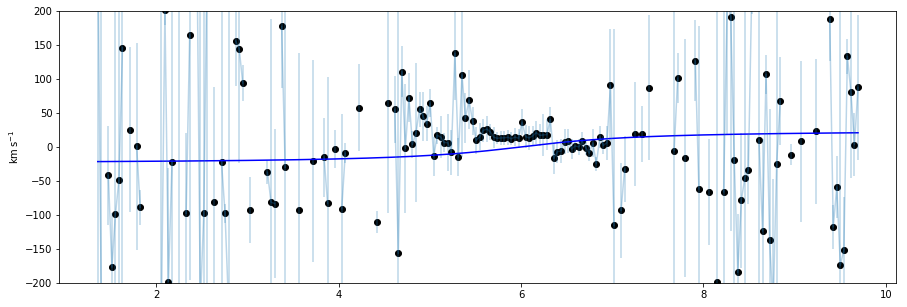

In [49]:
#lets model decide core


#takes out nan's so fit will actually do a fit
arr = np.asarray
@custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.001, beta=.001, sigma=50, omega=1, v_offset=0):
    dr = r - r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi + v_offset)

m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.0000001,.01), 'beta':(.0000001,.01),'sigma': (-200,200),'omega':(0,10)})
m_init.r_cen=6



fit = LevMarLSQFitter()
#print('here',m_init)
##m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target, y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections_target,y_axis_Gvelocity,yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta sigma omega
    ----- ----- ----- ----- -----
      0.0 1e-05 1e-05 -50.0   0.3


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


(-200, 200)

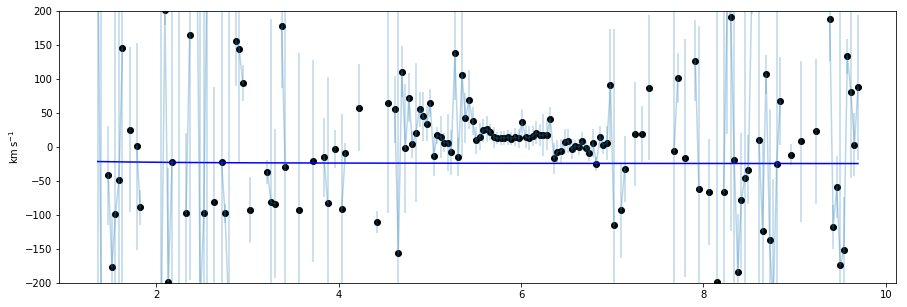

In [50]:
#with ccore from sections


arr=np.asarray


@models.custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.00001, beta=.00001, sigma=-50, omega=.3):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)



#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))

print(m)

#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target,y_axis_Gvelocity, color='k')
plt.errorbar(distances_sections_target, y_axis_Gvelocity, yerr=v_unc,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good


# overlay plot

(1385, 1414)

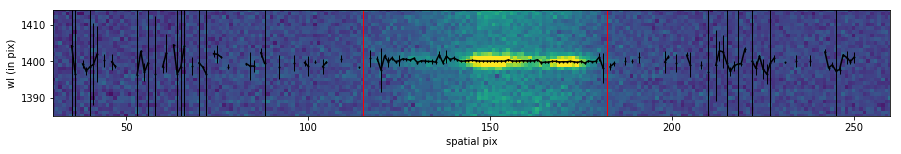

In [51]:
#in pixel space


y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs


subimg_fullccd =subimg2.data

vmin=-10
vmax=45
plt.figure(figsize=(15,25))
plt.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax)

plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED, color='k',s=1)
plt.errorbar(target_spacepix_fullccd, gaussmeans_specpix_fullccd_MASKED, yerr=y_unc_pixs,elinewidth=1,color='k')
plt.ylabel('wl (in pix)')
plt.xlabel('spatial pix')
plt.axvline(115,color='r',lw=1)
plt.axvline(182,color='r',lw=1)
#plt.axvline(96,color='r',lw=1)
# plt.axvline(127,color='r',lw=1)
# plt.axvline(173,color='r',lw=1)
# plt.axvline(212,color='r',lw=1)
# plt.axvline(234,color='r',lw=1)
# plt.axvline(245,color='r',lw=1)
# plt.axvline(102,color='r',lw=1) #uptick region


#plt.ylim(1392,1407)
plt.xlim(30,260)
plt.ylim(1385,1414)

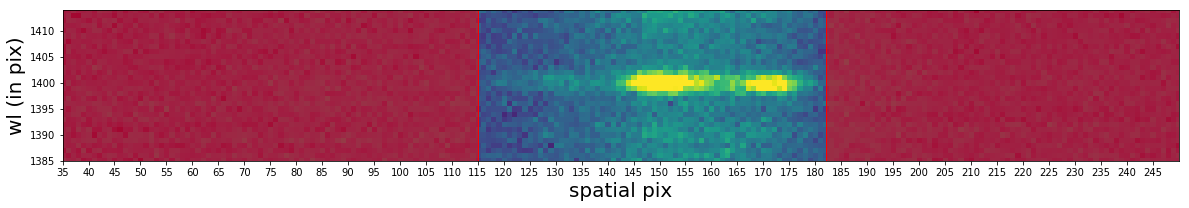

In [52]:
vmin=-10
vmax=45
fig, ax = plt.subplots(1,figsize=(20,10))
#plt.figure(figsize=(20,10))
ax.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax);
ax.set_ylabel('wl (in pix)',size=20)
ax.set_xlabel('spatial pix',size=20)
ax.set_ylim(1385,1414)
ax.axvline(115,color='r',lw=1)
ax.axvline(182,color='r',lw=1)


#to zoom into to where should mask inbtwn HII knots

ax.axvspan(35, 115, alpha=0.5, color='red')
ax.axvspan(182, 250, alpha=0.5, color='red')
# ax.axvspan(127, 173, alpha=0.5, color='red')
# ax.axvspan(212, 234, alpha=0.5, color='red')
# ax.axvspan(245, 250, alpha=0.5, color='red')
ax.set_xlim(35,250)
ax.set_xticks(np.arange(35, 250, 5.0));



# masking bad regions

In [53]:
all_bad_idx = np.concatenate([more2_badindices,evenmore_badindices])
all_bad_idxs = np.sort(all_bad_idx)

In [54]:
#collecting relevant info

#in full ccd pix want to mask these space[idx]
mask_reg1 = (0,115)
mask_reg2 =(182,250)


#pix arr corresponding to full ccd for real world arrays
pix_arr_ps = np.arange(np.min(target_spacepix_fullccd),np.max(target_spacepix_fullccd)+1,1)
pix_arr_ps


#converting bad fit idx from target pix space to full ccd pix space
bad_idx_fullccd = all_bad_idxs + space_pix_correction
bad_idx_fullccd

array([ 37,  43,  45,  48,  49,  50,  51,  52,  57,  59,  62,  67,  69,
        73,  77,  79,  80,  81,  82,  86,  89,  90,  91,  93,  94,  95,
        97,  98, 101, 103, 106, 107, 108, 110, 111, 112, 113, 115, 116,
       118, 182, 185, 186, 188, 190, 192, 193, 194, 195, 196, 197, 200,
       202, 203, 206, 207, 209, 211, 221, 229, 230, 232, 233, 235, 236,
       237, 239, 240, 241])

In [55]:
#connecting pix arrs from pix space to real world


pix_arr_rw =[]
for count,arr in enumerate(pix_arr_ps):
   # print(arr)
    arr = int(arr)
    if  arr <= 115: #region 1
        count = np.nan
    elif arr >= 182: #region 5
        count = np.nan
    elif arr in bad_idx_fullccd: #original bad fits 
        count = np.nan
    else:
        count = count
    pix_arr_rw.append(count)
pix_arr_rw_msk = np.asarray(pix_arr_rw)
pix_arr_rw_msk,len(pix_arr_rw_msk)

(array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  82.,  nan,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
        143., 144., 145., 146.,  nan, 

# mass modeling with masked regions

<eriksmodel(r_cen=6.64817562, alpha=0.0000001, beta=0.0000001, sigma=-39.77723154, omega=0.23833863, v_offset=-1.30420351)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


(-200, 200)

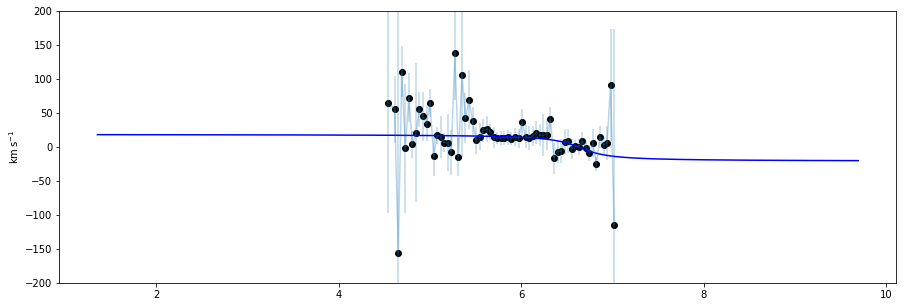

In [56]:
#takes out nan's so fit will actually do a fit

@custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.001, beta=.001, sigma=50, omega=1, v_offset=0):
    dr = r - r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi + v_offset)

#m_init = eriksmodel(bounds={'r_cen': (6,8), 'alpha':(.01,.00001), 'beta':(.01,.00001),'sigma': (0,170),'omega':(0,1)})
m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.0000001,.01), 'beta':(.0000001,.01),'sigma': (-200,200),'omega':(0,10)})


m_init.r_cen=6


fit = LevMarLSQFitter()
#print('here',m_init)
##m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
nan_msk = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections_target[nan_msk],y_axis_Gvelocity.value[nan_msk],weights=(1/(v_unc.value[nan_msk])**2))
print(repr(m))
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[nan_msk], y_axis_Gvelocity[nan_msk], color='k')
plt.errorbar(distances_sections_target[nan_msk],y_axis_Gvelocity[nan_msk],yerr=v_unc[nan_msk],alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good

<eriksmodel(r_cen=0., alpha=0.0000001, beta=0.0000001, sigma=-200., omega=3.57541214, v_offset=12.894728)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5,1,'uses core from sections')

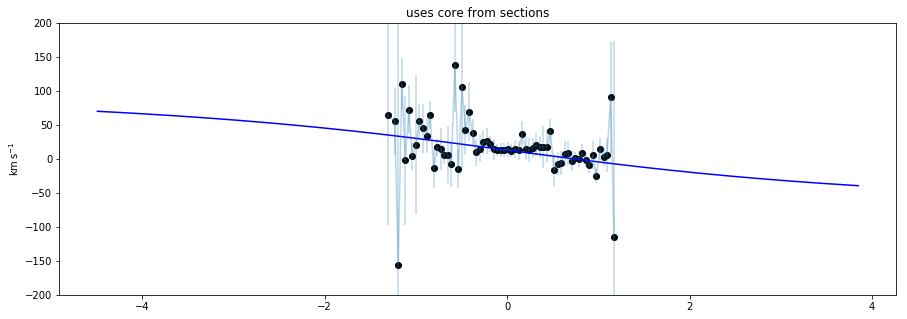

In [57]:
#takes out nan's so fit will actually do a fit

@custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.001, beta=.001, sigma=100, omega=1, v_offset=0):
   # dr = r - r_cen
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi + v_offset)

#m_init = eriksmodel(bounds={'r_cen': (6,8), 'alpha':(.01,.00001), 'beta':(.01,.00001),'sigma': (0,170),'omega':(0,1)})
m_init = eriksmodel(bounds={'alpha':(.0000001,.01), 'beta':(.0000001,.01),'sigma': (-200,200),'omega':(0,10)})


#m_init.r_cen=6


fit = LevMarLSQFitter()
#print('here',m_init)
##m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
nan_msk = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections[nan_msk],y_axis_Gvelocity.value[nan_msk],weights=(1/(v_unc.value[nan_msk])**2))
print(repr(m))
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections[nan_msk], y_axis_Gvelocity[nan_msk], color='k')
plt.errorbar(distances_sections[nan_msk],y_axis_Gvelocity[nan_msk],yerr=v_unc[nan_msk],alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('uses core from sections')

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


<eriksmodel(r_cen=0., alpha=0.0000001, beta=0.01, sigma=-300., omega=5.39729396, v_offset=12.9157004)>
it keeps pushing the limits of sigma & omega to obsurdly big


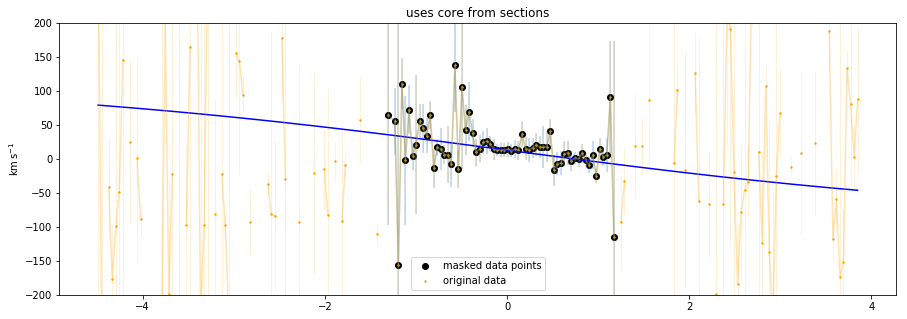

In [58]:
#plt.scatter(distances_sections_target[nan_msk2],y_axis_Gvelocity[nan_msk2], color='orange',label='original data')


#takes out nan's so fit will actually do a fit

@custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.00001, beta=.00001, sigma=-30, omega=.1, v_offset=0):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi + v_offset)

m_init = eriksmodel(bounds={'alpha':(.0000001,.01), 'beta':(.0000001,.01),'sigma': (-300,100),'omega':(0,10)})



fit = LevMarLSQFitter()
nan_msk = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections[nan_msk],y_axis_Gvelocity.value[nan_msk],weights=(1/(v_unc.value[nan_msk])**2))
print(repr(m))
                            
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections[nan_msk], y_axis_Gvelocity[nan_msk], color='k',label='masked data points')
plt.errorbar(distances_sections[nan_msk],y_axis_Gvelocity[nan_msk],yerr=v_unc[nan_msk],alpha=.3)
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')

#original data
plt.scatter(distances_sections, y_axis_Gvelocity, s=2,color='orange',label='original data')
plt.errorbar(distances_sections,y_axis_Gvelocity,yerr=v_unc,alpha=.3,color='orange',elinewidth=.5)


plt.legend()

#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('uses core from sections');
print('it keeps pushing the limits of sigma & omega to obsurdly big')

<eriksmodel(r_cen=6.64817562, alpha=0.0000001, beta=0.0000001, sigma=-39.77723154, omega=0.23833863, v_offset=-1.30420351)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


(-200, 200)

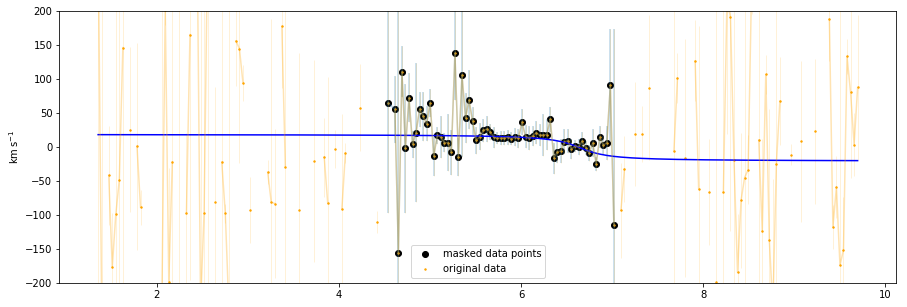

In [59]:


#takes out nan's so fit will actually do a fit

@custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.001, beta=.001, sigma=50, omega=1, v_offset=0):
    dr = r - r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi + v_offset)

#m_init = eriksmodel(bounds={'r_cen': (6,8), 'alpha':(.01,.00001), 'beta':(.01,.00001),'sigma': (0,170),'omega':(0,1)})
m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.0000001,.01), 'beta':(.0000001,.01),'sigma': (-200,200),'omega':(0,10)})


m_init.r_cen=6


fit = LevMarLSQFitter()
#print('here',m_init)
##m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
nan_msk = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections_target[nan_msk],y_axis_Gvelocity.value[nan_msk],weights=(1/(v_unc.value[nan_msk])**2))
print(repr(m))
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[nan_msk], y_axis_Gvelocity[nan_msk], color='k',label='masked data points')
plt.errorbar(distances_sections_target[nan_msk],y_axis_Gvelocity[nan_msk],yerr=v_unc[nan_msk],alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')

#original data
plt.scatter(distances_sections_target, y_axis_Gvelocity, s=2,color='orange',label='original data')
plt.errorbar(distances_sections_target,y_axis_Gvelocity,yerr=v_unc,alpha=.3,color='orange',elinewidth=.5)


plt.legend()

#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good


<eriksmodel(r_cen=6.64817562, alpha=0.0000001, beta=0.0000001, sigma=-39.77723154, omega=0.23833863, v_offset=-1.30420351)>


/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


(4.4, 7.2)

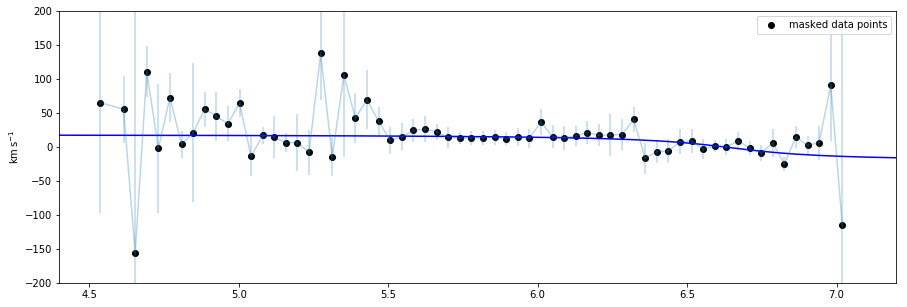

In [60]:


#takes out nan's so fit will actually do a fit

@custom_model #very necessary line
def eriksmodel(r, r_cen=0, alpha=.001, beta=.001, sigma=50, omega=1, v_offset=0):
    dr = r - r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi + v_offset)

#m_init = eriksmodel(bounds={'r_cen': (6,8), 'alpha':(.01,.00001), 'beta':(.01,.00001),'sigma': (0,170),'omega':(0,1)})
m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.0000001,.01), 'beta':(.0000001,.01),'sigma': (-200,200),'omega':(0,10)})


m_init.r_cen=6


fit = LevMarLSQFitter()
#print('here',m_init)
##m = fit(m_init, arr(distances_sections_target), arr(y_axis_Gvelocity.value),weights=arr(1/(v_unc.value)**2))
nan_msk = ~np.isnan(pix_arr_rw_msk)
m = fit(m_init, distances_sections_target[nan_msk],y_axis_Gvelocity.value[nan_msk],weights=(1/(v_unc.value[nan_msk])**2))
print(repr(m))
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target[nan_msk], y_axis_Gvelocity[nan_msk], color='k',label='masked data points')
plt.errorbar(distances_sections_target[nan_msk],y_axis_Gvelocity[nan_msk],yerr=v_unc[nan_msk],alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
plt.legend()

#plt.ylim(-2000,2000)
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.xlim(4.4,7.2)
